# Quasi ARDL model

Now we will extend our OLS model with additional variables which allow us add time dimension!

### Dependencies loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import pickle

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 150)

# np.random.seed(1916) #uncomment if you want your code to be reproducible; for the purposes of our activity, let's add some randomness to the results

### Data loading

In [2]:
preprocessed_output_data_path = "../data/output"

df = pd.read_csv(f"{preprocessed_output_data_path}/train_fe.csv", index_col=0)

fr = pd.read_excel(f"{preprocessed_output_data_path}/feature_ranking.xlsx", index_col=0)

### Feature engineering for ARDL model

We can omit this step, because all crucial transformations like: mathematical transformations, feature creation, dummification have been already applied.

### Final feature selection for ARDL model

#### Feature ranking

We will start with prepared in previous notebook "feature ranking".

In [3]:
fr.sort_values("mi_score", ascending=False, inplace=True)

In [4]:
fr.head()

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
etr_y_past,1.009402,1.304040e-84,1,0.520405,NaN,1
etr_y_ma,0.825650,2.473770e-125,1,0.526871,NaN,1
txt,0.633067,5.246456e-13,1,0.368732,1.466269e-05,1
diff,0.632640,2.257712e-02,1,-0.291716,NaN,1
ni,0.613297,1.747230e-09,1,0.263458,-3.442000e-07,7


Let's create two baseline models for ARDL based on feature ranking table!

In [5]:
br_features = fr[fr.boruta_rank.isin([1, 2, 3])].index.tolist()

In [6]:
print(br_features)

['etr_y_past', 'etr_y_ma', 'txt', 'diff', 'pi', 'diff_ma', 'WB_GDPpc', 'txt_cat_(-63.011, -34.811]', 'dlc_cat_(176.129, 200.9]']


In [7]:
mi_features = fr.iloc[0:20].index.tolist()

In [8]:
print(mi_features)

['etr_y_past', 'etr_y_ma', 'txt', 'diff', 'ni', 'pi', 'intant', 'intant_sqrt', 'ta', 'revenue', 'roa', 'roa_clip', 'diff_ma', 'capex', 'dlc', 'ta_log', 'cce', 'intan_past', 'dltt', 'sale']


In [9]:
fr["corr_abs"] = np.abs(fr["corr"])

In [10]:
fr.sort_values("corr_abs", ascending=False, inplace=True)

In [11]:
corr_features = fr.iloc[0:20].index.tolist()

#### Recursive Feature Elimination 

In [12]:
rfe_candidates = [
    "rok",
    "ta",
    "txt",
    "pi",
    "str",
    "xrd",
    "ni",
    "ppent",
    "intant",
    "dlc",
    "dltt",
    "capex",
    "revenue",
    "cce",
    "adv",
    "diff",
    "roa",
    "lev",
    "intan",
    "rd",
    "ppe",
    "sale",
    "cash_holdings",
    "adv_expenditure",
    "capex2",
    "cfc",
    "dta",
    "capex2_scaled",
    "y_v2x_polyarchy",
    "y_e_p_polity",
    "y_BR_Democracy",
    "WB_GDPgrowth",
    "WB_GDPpc",
    "WB_Inflation",
    "rr_per_country",
    "rr_per_sector",
    "sektor_consumer discretionary",
    "sektor_consumer staples",
    "sektor_energy",
    "sektor_health care",
    "sektor_industrials",
    "sektor_materials",
    "sektor_real estate",
    "sektor_technology",
    "sektor_utilities",
    "gielda_2",
    "gielda_3",
    "gielda_4",
    "gielda_5",
    "ta_log",
    "txt_cat_(-63.011, -34.811]",
    "txt_cat_(-34.811, 0.488]",
    "txt_cat_(0.488, 24.415]",
    "txt_cat_(24.415, 25.05]",
    "txt_cat_(25.05, 308.55]",
    "txt_cat_(308.55, 327.531]",
    "txt_cat_(327.531, inf]",
    "pi_cat_(-8975.0, -1.523]",
    "pi_cat_(-1.523, 157.119]",
    "pi_cat_(157.119, 465.9]",
    "pi_cat_(465.9, 7875.5]",
    "pi_cat_(7875.5, 8108.5]",
    "pi_cat_(8108.5, inf]",
    "str_cat_(0.0875, 0.192]",
    "str_cat_(0.192, 0.28]",
    "str_cat_(0.28, inf]",
    "xrd_exists",
    "ni_profit",
    "ni_profit_20000",
    "ppent_sqrt",
    "intant_sqrt",
    "dlc_cat_(42.262, 176.129]",
    "dlc_cat_(176.129, 200.9]",
    "dlc_cat_(200.9, inf]",
    "dltt_cat_(39.38, 327.85]",
    "dltt_cat_(327.85, 876.617]",
    "dltt_cat_(876.617, inf]",
    "capex_cat_(7.447, 79.55]",
    "capex_cat_(79.55, 5451.0]",
    "capex_cat_(5451.0, inf]",
    "revenue_cat_(0.174, 1248.817]",
    "revenue_cat_(1248.817, 4233.587]",
    "revenue_cat_(4233.587, inf]",
    "cce_cat_(5.619, 63.321]",
    "cce_cat_(63.321, inf]",
    "adv_cat_(0.3, 874.5]",
    "adv_cat_(874.5, inf]",
    "diff_positive",
    "roa_clip",
    "lev_sqrt",
    "intan_pow2",
    "rd_sqrt",
    "ppe_clip",
    "cash_holdings_sqrt",
    "adv_expenditure_positive",
    "diff_dta",
    "cfc_dta",
    "etr_y_past",
    "etr_y_ma",
    "diff_ma",
    "roa_ma",
    "lev_ma",
    "intan_ma",
    "ppe_ma",
    "sale_ma",
    "cash_holdings_ma",
    "roa_past",
    "lev_past",
    "intan_past",
    "ppe_past",
    "sale_past",
    "cash_holdings_past",
]
rfe_candidates.remove("ta_log")
rfe_candidates.remove("ppent_sqrt")
rfe_candidates.remove("intant_sqrt")
rfe_candidates.remove("roa")
rfe_candidates.remove("lev")
rfe_candidates.remove("intan")
rfe_candidates.remove("rd_sqrt")
rfe_candidates.remove("ppe")
rfe_candidates.remove("cash_holdings_sqrt")

In [13]:
rfe_candidates_without_disc = [i for i in rfe_candidates if "]" not in i]

In [14]:
estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=5, min_features_to_select=7)
selector = selector.fit(
    df.loc[:, rfe_candidates_without_disc].values, df.loc[:, "etr"].values.ravel()
)

In [15]:
df.loc[:, rfe_candidates_without_disc].iloc[:, selector.support_].columns.tolist()

['str',
 'adv_expenditure',
 'dta',
 'y_e_p_polity',
 'gielda_3',
 'gielda_4',
 'etr_y_ma']

In [16]:
rfe_candidates_without_disc = (
    df.loc[:, rfe_candidates_without_disc].iloc[:, selector.support_].columns.tolist()
)

In [17]:
estimator = LinearRegression()
selector = RFECV(
    estimator,
    step=1,
    cv=5,
    min_features_to_select=7,
)
selector = selector.fit(
    df.loc[:, rfe_candidates].values, df.loc[:, "etr"].values.ravel()
)

In [18]:
df.loc[:, rfe_candidates].iloc[:, selector.support_].columns.tolist()

['dta',
 'y_e_p_polity',
 'gielda_3',
 'gielda_4',
 'pi_cat_(-8975.0, -1.523]',
 'pi_cat_(-1.523, 157.119]',
 'pi_cat_(157.119, 465.9]',
 'pi_cat_(465.9, 7875.5]',
 'cfc_dta']

In [19]:
rfe_candidates = df.loc[:, rfe_candidates].iloc[:, selector.support_].columns.tolist()

In [20]:
rfe_candidates

['dta',
 'y_e_p_polity',
 'gielda_3',
 'gielda_4',
 'pi_cat_(-8975.0, -1.523]',
 'pi_cat_(-1.523, 157.119]',
 'pi_cat_(157.119, 465.9]',
 'pi_cat_(465.9, 7875.5]',
 'cfc_dta']

Let's investigate permutation importance of such candidates!

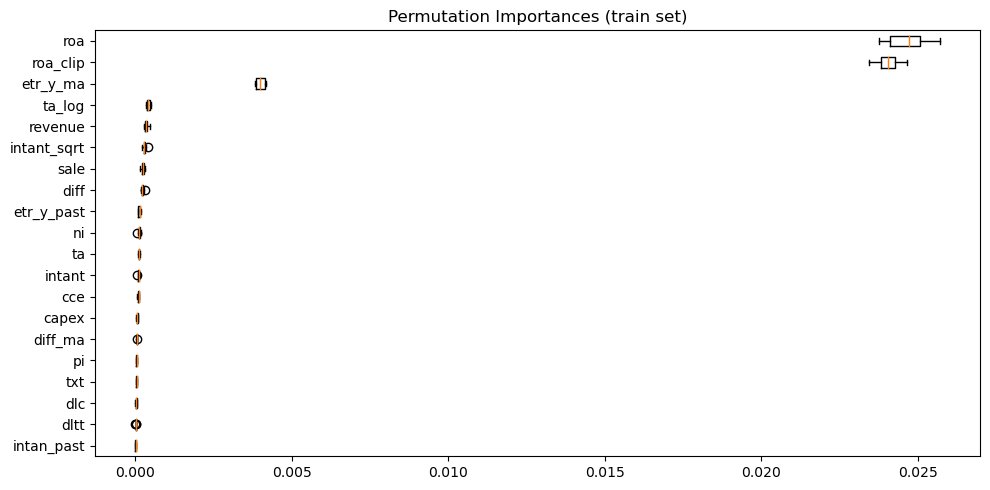

In [21]:
inputX = mi_features
estimator = LinearRegression()
estimator.fit(df.loc[:, inputX].values, df.loc[:, "etr"].values.ravel())
result = permutation_importance(
    estimator,
    df.loc[:, inputX].values,
    df.loc[:, "etr"].values.ravel(),
    n_repeats=10,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=2,
)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(10, 5))

ax.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=df.loc[:, inputX].columns[sorted_idx],
)
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

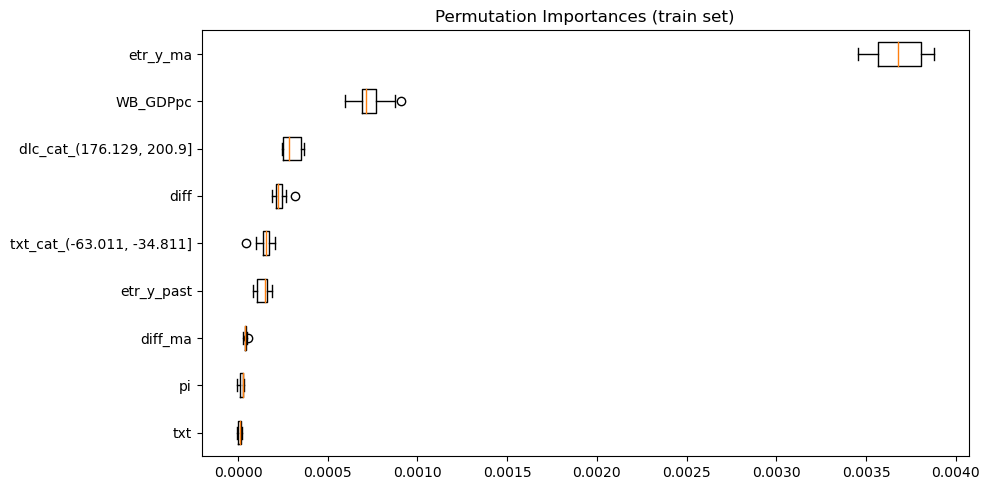

In [22]:
inputX = br_features
estimator = LinearRegression()
estimator.fit(df.loc[:, inputX].values, df.loc[:, "etr"].values.ravel())
result = permutation_importance(
    estimator,
    df.loc[:, inputX].values,
    df.loc[:, "etr"].values.ravel(),
    n_repeats=10,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=2,
)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(10, 5))

ax.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=df.loc[:, inputX].columns[sorted_idx],
)
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

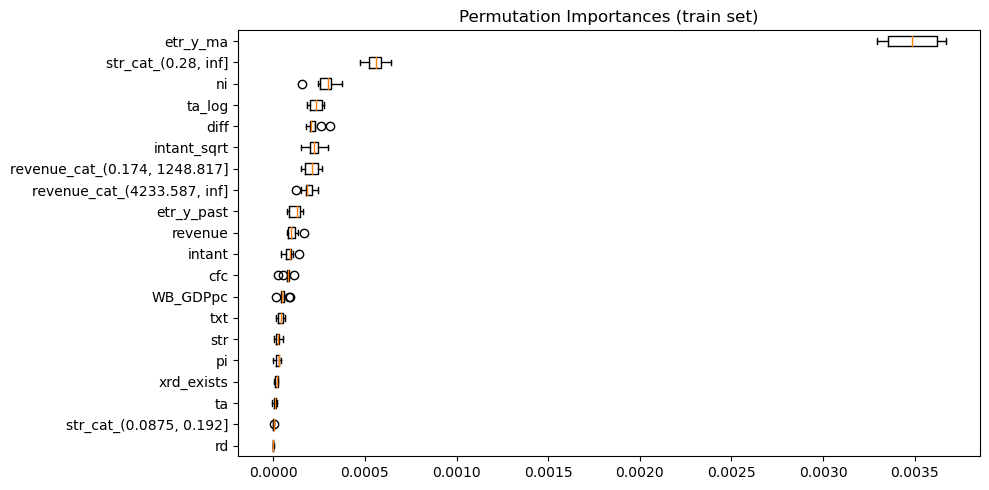

In [23]:
inputX = corr_features
estimator = LinearRegression()
estimator.fit(df.loc[:, inputX].values, df.loc[:, "etr"].values.ravel())
result = permutation_importance(
    estimator,
    df.loc[:, inputX].values,
    df.loc[:, "etr"].values.ravel(),
    n_repeats=10,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=2,
)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(10, 5))

ax.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=df.loc[:, inputX].columns[sorted_idx],
)
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

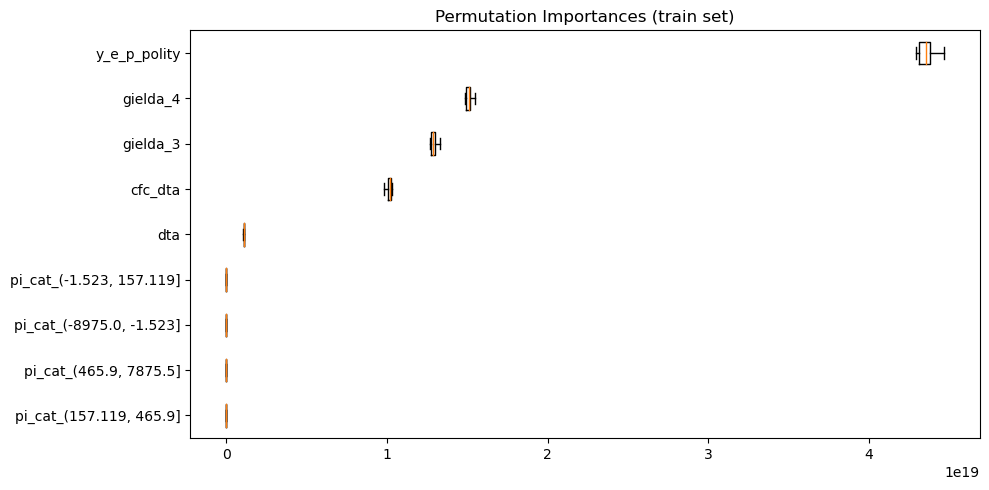

In [24]:
inputX = rfe_candidates
estimator = LinearRegression()
estimator.fit(df.loc[:, inputX].values, df.loc[:, "etr"].values.ravel())
result = permutation_importance(
    estimator,
    df.loc[:, inputX].values,
    df.loc[:, "etr"].values.ravel(),
    n_repeats=10,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=2,
)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(10, 5))

ax.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=df.loc[:, inputX].columns[sorted_idx],
)
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

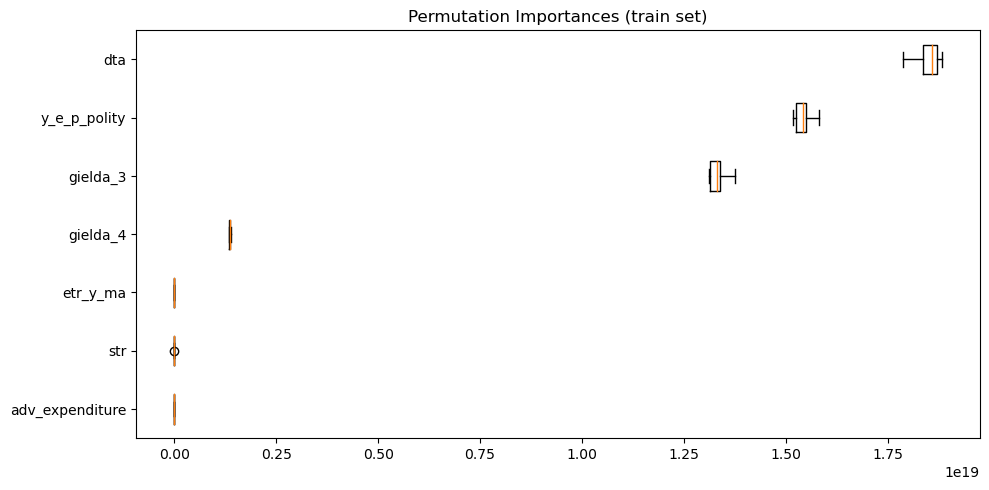

In [25]:
inputX = rfe_candidates_without_disc
estimator = LinearRegression()
estimator.fit(df.loc[:, inputX].values, df.loc[:, "etr"].values.ravel())
result = permutation_importance(
    estimator,
    df.loc[:, inputX].values,
    df.loc[:, "etr"].values.ravel(),
    n_repeats=10,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=2,
)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(10, 5))

ax.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=df.loc[:, inputX].columns[sorted_idx],
)
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

#### Permutation importance

Let's try something new for us - permutation importance for feature selection.

In [26]:
rfe_candidates = [
    "rok",
    "ta",
    "txt",
    "pi",
    "str",
    "xrd",
    "ni",
    "ppent",
    "intant",
    "dlc",
    "dltt",
    "capex",
    "revenue",
    "cce",
    "adv",
    "diff",
    "rd",
    "sale",
    "cash_holdings",
    "adv_expenditure",
    "capex2",
    "cfc",
    "dta",
    "capex2_scaled",
    "y_v2x_polyarchy",
    "y_e_p_polity",
    "y_BR_Democracy",
    "WB_GDPgrowth",
    "WB_GDPpc",
    "WB_Inflation",
    "rr_per_country",
    "rr_per_sector",
    "sektor_consumer discretionary",
    "sektor_consumer staples",
    "sektor_energy",
    "sektor_health care",
    "sektor_industrials",
    "sektor_materials",
    "sektor_real estate",
    "sektor_technology",
    "sektor_utilities",
    "gielda_2",
    "gielda_3",
    "gielda_4",
    "gielda_5",
    "txt_cat_(-63.011, -34.811]",
    "txt_cat_(-34.811, 0.488]",
    "txt_cat_(0.488, 24.415]",
    "txt_cat_(24.415, 25.05]",
    "txt_cat_(25.05, 308.55]",
    "txt_cat_(308.55, 327.531]",
    "txt_cat_(327.531, inf]",
    "pi_cat_(-8975.0, -1.523]",
    "pi_cat_(-1.523, 157.119]",
    "pi_cat_(157.119, 465.9]",
    "pi_cat_(465.9, 7875.5]",
    "pi_cat_(7875.5, 8108.5]",
    "pi_cat_(8108.5, inf]",
    "str_cat_(0.0875, 0.192]",
    "str_cat_(0.192, 0.28]",
    "str_cat_(0.28, inf]",
    "xrd_exists",
    "ni_profit",
    "ni_profit_20000",
    "dlc_cat_(42.262, 176.129]",
    "dlc_cat_(176.129, 200.9]",
    "dlc_cat_(200.9, inf]",
    "dltt_cat_(39.38, 327.85]",
    "dltt_cat_(327.85, 876.617]",
    "dltt_cat_(876.617, inf]",
    "capex_cat_(7.447, 79.55]",
    "capex_cat_(79.55, 5451.0]",
    "capex_cat_(5451.0, inf]",
    "revenue_cat_(0.174, 1248.817]",
    "revenue_cat_(1248.817, 4233.587]",
    "revenue_cat_(4233.587, inf]",
    "cce_cat_(5.619, 63.321]",
    "cce_cat_(63.321, inf]",
    "adv_cat_(0.3, 874.5]",
    "adv_cat_(874.5, inf]",
    "diff_positive",
    "roa_clip",
    "lev_sqrt",
    "intan_pow2",
    "ppe_clip",
    "adv_expenditure_positive",
    "diff_dta",
    "cfc_dta",
    "etr_y_past",
    "etr_y_ma",
    "diff_ma",
    "roa_ma",
    "lev_ma",
    "intan_ma",
    "ppe_ma",
    "sale_ma",
    "cash_holdings_ma",
    "roa_past",
    "lev_past",
    "intan_past",
    "ppe_past",
    "sale_past",
    "cash_holdings_past",
]

In [27]:
estimator = LinearRegression()
estimator.fit(df.loc[:, rfe_candidates].values, df.loc[:, "etr"].values.ravel())
result = permutation_importance(
    estimator,
    df.loc[:, rfe_candidates].values,
    df.loc[:, "etr"].values.ravel(),
    n_repeats=10,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=2,
)
sorted_idx = result.importances_mean.argsort()

In [28]:
sorted_idx = sorted_idx[-20:]

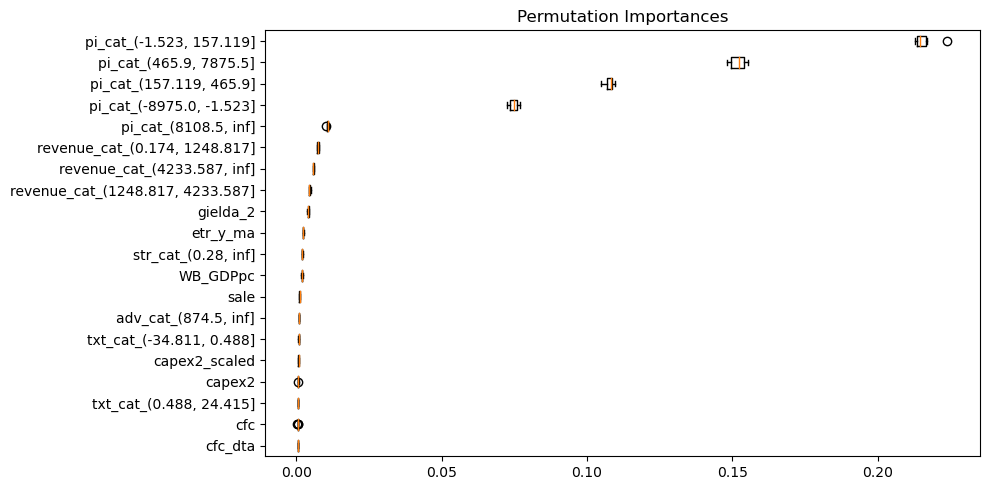

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=df.loc[:, rfe_candidates].columns[sorted_idx],
)
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

In [30]:
pi_var = df.loc[:, rfe_candidates].columns[sorted_idx].tolist()
pi_var.remove("capex2")

In [31]:
estimator = LinearRegression()
estimator.fit(df.loc[:, pi_var].values, df.loc[:, "etr"].values.ravel())
result = permutation_importance(
    estimator,
    df.loc[:, pi_var].values,
    df.loc[:, "etr"].values.ravel(),
    n_repeats=10,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=2,
)
sorted_idx = result.importances_mean.argsort()

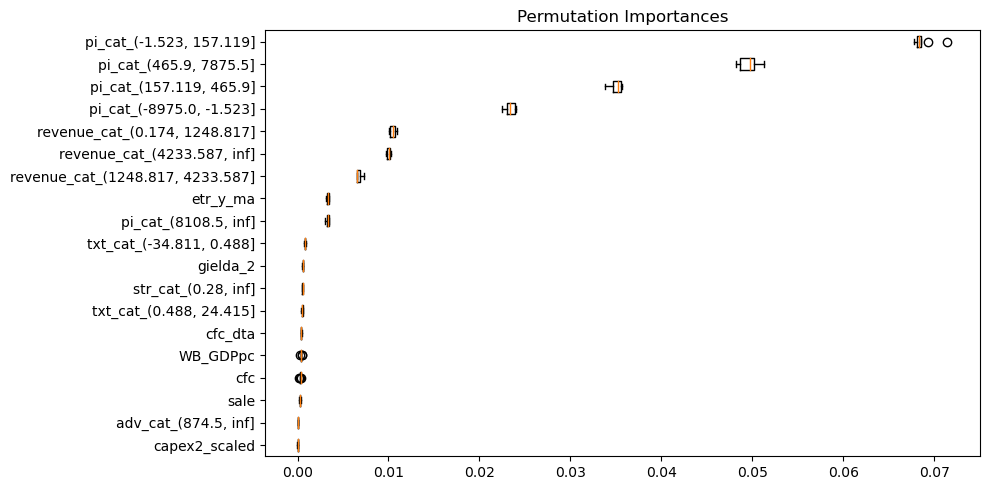

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=df.loc[:, pi_var].columns[sorted_idx],
)
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

In [33]:
pi_var_prim = pi_var[-11:]

#### Forward elimination

Finally let's try backward feature selection!

In [34]:
candidates = [
    "rok",
    "ta",
    "txt",
    "pi",
    "str",
    "xrd",
    "ni",
    "ppent",
    "intant",
    "dlc",
    "dltt",
    "capex",
    "revenue",
    "cce",
    "adv",
    "diff",
    "rd",
    "sale",
    "cash_holdings",
    "adv_expenditure",
    "capex2",
    "cfc",
    "dta",
    "capex2_scaled",
    "y_v2x_polyarchy",
    "y_e_p_polity",
    "y_BR_Democracy",
    "WB_GDPgrowth",
    "WB_GDPpc",
    "WB_Inflation",
    "rr_per_country",
    "rr_per_sector",
    "sektor_consumer discretionary",
    "sektor_consumer staples",
    "sektor_energy",
    "sektor_health care",
    "sektor_industrials",
    "sektor_materials",
    "sektor_real estate",
    "sektor_technology",
    "sektor_utilities",
    "gielda_2",
    "gielda_3",
    "gielda_4",
    "gielda_5",
    "txt_cat_(-63.011, -34.811]",
    "txt_cat_(-34.811, 0.488]",
    "txt_cat_(0.488, 24.415]",
    "txt_cat_(24.415, 25.05]",
    "txt_cat_(25.05, 308.55]",
    "txt_cat_(308.55, 327.531]",
    "txt_cat_(327.531, inf]",
    "pi_cat_(-8975.0, -1.523]",
    "pi_cat_(-1.523, 157.119]",
    "pi_cat_(157.119, 465.9]",
    "pi_cat_(465.9, 7875.5]",
    "pi_cat_(7875.5, 8108.5]",
    "pi_cat_(8108.5, inf]",
    "str_cat_(0.0875, 0.192]",
    "str_cat_(0.192, 0.28]",
    "str_cat_(0.28, inf]",
    "xrd_exists",
    "ni_profit",
    "ni_profit_20000",
    "dlc_cat_(42.262, 176.129]",
    "dlc_cat_(176.129, 200.9]",
    "dlc_cat_(200.9, inf]",
    "dltt_cat_(39.38, 327.85]",
    "dltt_cat_(327.85, 876.617]",
    "dltt_cat_(876.617, inf]",
    "capex_cat_(7.447, 79.55]",
    "capex_cat_(79.55, 5451.0]",
    "capex_cat_(5451.0, inf]",
    "revenue_cat_(0.174, 1248.817]",
    "revenue_cat_(1248.817, 4233.587]",
    "revenue_cat_(4233.587, inf]",
    "cce_cat_(5.619, 63.321]",
    "cce_cat_(63.321, inf]",
    "adv_cat_(0.3, 874.5]",
    "adv_cat_(874.5, inf]",
    "diff_positive",
    "roa_clip",
    "lev_sqrt",
    "intan_pow2",
    "ppe_clip",
    "adv_expenditure_positive",
    "diff_dta",
    "cfc_dta",
    "etr_y_past",
    "etr_y_ma",
    "diff_ma",
    "roa_ma",
    "lev_ma",
    "intan_ma",
    "ppe_ma",
    "sale_ma",
    "cash_holdings_ma",
    "roa_past",
    "lev_past",
    "intan_past",
    "ppe_past",
    "sale_past",
    "cash_holdings_past",
]

In [35]:
model = LinearRegression()

In [36]:
sf = SFS(
    model,
    k_features=(1, 10),
    forward=True,
    floating=False,
    verbose=0,
    scoring="neg_mean_squared_error",
    cv=5,
)

sffit = sf.fit(df.loc[:, candidates].values, df.loc[:, "etr"].values.ravel())

sf_features = df.loc[:, candidates].columns[list(sffit.k_feature_idx_)]

In [37]:
sf_features

Index(['sale', 'cfc', 'txt_cat_(-34.811, 0.488]', 'txt_cat_(0.488, 24.415]',
       'txt_cat_(308.55, 327.531]', 'pi_cat_(7875.5, 8108.5]',
       'str_cat_(0.28, inf]', 'dlc_cat_(176.129, 200.9]', 'diff_positive',
       'etr_y_ma'],
      dtype='object')

### Models performance in a proper CV

We would like to fight against data leakage in our CV, so we will treat it like a panel problem with a rolling window. We now based on our experience that this kind of approach is crucial to fight against overfitting.

Sliding window:
 * T: 2005 - 2008; V: 2009
 * T: 2005 - 2009; V: 2010
 * T: 2005 - 2010; V: 2011
 * ...

In [38]:
df = df.sort_values(by="rok").reset_index(drop=True)

In [39]:
def proper_CV(x, y, model, display_res=False):
    train_score = list()
    valid_score = list()
    train_indexes = [0, 1452]
    valid_indexes = [1452, 1815]
    for i in range(0, 6):
        train_x = x[x.index.isin(range(train_indexes[0], train_indexes[1]))]
        train_y = y[y.index.isin(range(train_indexes[0], train_indexes[1]))]
        valid_x = x[x.index.isin(range(valid_indexes[0], valid_indexes[1]))]
        valid_y = y[y.index.isin(range(valid_indexes[0], valid_indexes[1]))]

        model.fit(train_x.values, train_y.values.ravel())

        pred_y_train = model.predict(train_x.values)
        rmse = np.sqrt(mean_squared_error(train_y, pred_y_train))
        train_score.append(rmse)

        pred_y_val = model.predict(valid_x.values)
        rmse = np.sqrt(mean_squared_error(valid_y, pred_y_val))
        valid_score.append(rmse)

        train_indexes = [0, valid_indexes[1]]
        valid_indexes = [train_indexes[1], valid_indexes[1] + 363]

    if display_res == True:
        view = pd.DataFrame([train_score, valid_score]).T.rename(
            columns={0: "cv_train", 1: "cv_val"}
        )
        display(view)
        return train_score, valid_score, view
    else:
        return train_score, valid_score

In [40]:
model = LinearRegression()
cv_output1 = proper_CV(
    df.loc[:, mi_features], df.loc[:, "etr"], model, display_res=True
)

,cv_train,cv_val
0,0.132887,0.180727
1,0.137568,0.144853
2,0.138002,0.147607
3,0.139136,0.145071
4,0.139685,0.207354
5,0.139576,0.132555


In [41]:
model = LinearRegression()
cv_output2 = proper_CV(
    df.loc[:, corr_features], df.loc[:, "etr"], model, display_res=True
)

,cv_train,cv_val
0,0.132525,0.176208
1,0.136937,0.142398
2,0.137332,0.144886
3,0.138266,0.145311
4,0.139004,0.208335
5,0.138860,0.135515


In [42]:
model = LinearRegression()
cv_output3 = proper_CV(
    df.loc[:, br_features], df.loc[:, "etr"], model, display_res=True
)

,cv_train,cv_val
0,0.133058,0.178367
1,0.137306,0.139817
2,0.137286,0.147315
3,0.138559,0.143718
4,0.139112,0.210931
5,0.139099,0.127751


In [43]:
model = LinearRegression()
cv_output4 = proper_CV(
    df.loc[:, rfe_candidates], df.loc[:, "etr"], model, display_res=True
)

,cv_train,cv_val
0,0.126980,0.186750
1,0.131531,0.141275
2,0.131602,0.149313
3,0.133517,0.145249
4,0.134083,0.198899
5,0.133837,0.130041


In [44]:
model = LinearRegression()
cv_output5 = proper_CV(
    df.loc[:, rfe_candidates_without_disc], df.loc[:, "etr"], model, display_res=True
)

,cv_train,cv_val
0,0.136745,0.153326
1,0.138991,0.141380
2,0.139194,0.151756
3,0.141014,0.145053
4,0.141513,0.131512
5,0.140410,0.134634


In [45]:
model = LinearRegression()
cv_output6 = proper_CV(df.loc[:, pi_var], df.loc[:, "etr"], model, display_res=True)

,cv_train,cv_val
0,0.135036,0.151068
1,0.136988,0.137766
2,0.136798,0.151330
3,0.138805,0.142335
4,0.139133,0.129867
5,0.138028,0.134557


In [46]:
model = LinearRegression()
cv_output7 = proper_CV(
    df.loc[:, pi_var_prim], df.loc[:, "etr"], model, display_res=True
)

,cv_train,cv_val
0,0.135669,0.153404
1,0.138062,0.138732
2,0.137954,0.151930
3,0.139915,0.145173
4,0.140526,0.129656
5,0.139281,0.134648


In [47]:
model = LinearRegression()
cv_output8 = proper_CV(
    df.loc[:, sf_features], df.loc[:, "etr"], model, display_res=True
)

,cv_train,cv_val
0,0.135084,0.149512
1,0.136924,0.133315
2,0.135998,0.150370
3,0.138056,0.140874
4,0.138355,0.128921
5,0.137231,0.133595


In [48]:
pd.DataFrame(
    [
        cv_output1[2].mean().tolist(),
        cv_output2[2].mean().tolist(),
        cv_output3[2].mean().tolist(),
        cv_output4[2].mean().tolist(),
        cv_output5[2].mean().tolist(),
        cv_output6[2].mean().tolist(),
        cv_output7[2].mean().tolist(),
        cv_output8[2].mean().tolist(),
    ],
    columns=["train_mean", "test_mean"],
)

,train_mean,test_mean
0,0.137809,0.159694
1,0.137154,0.158776
2,0.137403,0.157983
3,0.131925,0.158588
4,0.139645,0.142943
5,0.137465,0.141154
6,0.138568,0.142257
7,0.136941,0.139431


In [49]:
pd.DataFrame(
    [
        cv_output1[2].std().tolist(),
        cv_output2[2].std().tolist(),
        cv_output3[2].std().tolist(),
        cv_output4[2].std().tolist(),
        cv_output5[2].std().tolist(),
        cv_output6[2].std().tolist(),
        cv_output7[2].std().tolist(),
        cv_output8[2].std().tolist(),
    ],
    columns=["train_std", "test_std"],
)

,train_std,test_std
0,0.002558,0.028392
1,0.002411,0.028084
2,0.002282,0.030920
3,0.002667,0.027556
4,0.001732,0.008855
5,0.001514,0.008782
6,0.001743,0.009544
7,0.001238,0.009003


8th models seems to be the best one!

In [50]:
print(sf_features)

Index(['sale', 'cfc', 'txt_cat_(-34.811, 0.488]', 'txt_cat_(0.488, 24.415]',
       'txt_cat_(308.55, 327.531]', 'pi_cat_(7875.5, 8108.5]',
       'str_cat_(0.28, inf]', 'dlc_cat_(176.129, 200.9]', 'diff_positive',
       'etr_y_ma'],
      dtype='object')


### Fit final model and save it

In [51]:
model = LinearRegression()
model.fit(df.loc[:, sf_features].values, df.loc[:, "etr"].values.ravel())

LinearRegression()

In [52]:
filename = "../models/ardl.sav"

In [53]:
pickle.dump(model, open(filename, "wb"))